#IMPORT E SETUP

In [1]:
import tensorflow as tf
from PIL import Image
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import random
from google.colab import drive
import os
from keras.callbacks import ModelCheckpoint
!pip install -q -U keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os

# Collegare Google Drive
drive.mount('/content/drive', force_remount=True)

# Creare una cartella chiamata 'AAoMC' su Google Drive per salvare i dati
base_path = "/content/drive/My Drive/AAoMC"
if not os.path.exists(base_path):
    os.makedirs(base_path)


Mounted at /content/drive


#METODI AUSILISARI PER IL TRAINING

In [3]:
import os
import re
import pandas as pd
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def test(): return 'prova'

class CSVLoggerCallback(Callback):
    def __init__(self, path):
        super(CSVLoggerCallback, self).__init__()
        self.path = path
        self.history_file = os.path.join(self.path, 'training_history.csv')

        # Crea la directory se non esiste
        if not os.path.exists(self.path):
            os.makedirs(self.path)

        # Controllo se il file CSV esiste già
        self.file_exists = os.path.exists(self.history_file)

    def on_epoch_end(self, epoch, logs=None):
        # Estrazione dei dati di interesse alla fine dell'epoca
        logs = logs or {}
        epoch_data = {
            'epoch': [epoch + 1],
            'training_accuracy': [logs.get('accuracy')],
            'training_loss': [logs.get('loss')],
            'validation_accuracy': [logs.get('val_accuracy')],
            'validation_loss': [logs.get('val_loss')]
        }

        # Creiamo un DataFrame per la singola epoca
        epoch_df = pd.DataFrame(epoch_data)

        # Se il file esiste già, appendo i nuovi dati senza intestazione
        if self.file_exists:
            epoch_df.to_csv(self.history_file, mode='a', header=False, index=False)
        else:
            # Se il file non esiste, lo creo con l'intestazione
            epoch_df.to_csv(self.history_file, index=False)
            self.file_exists = True  # Ora il file esiste

        print(f"Salvati i dati dell'epoca {epoch + 1} in {self.history_file}")



def generate_plot(path, epoch=0):
    # Percorso del file CSV contenente la storia dell'addestramento
    history_file = os.path.join(path, 'training_history.csv')

    # Controlla se il file CSV esiste
    if not os.path.exists(history_file):
        print(f"File {history_file} non trovato!")
        return

    # Carica i dati dal file CSV
    try:
        history_df = pd.read_csv(history_file)
    except Exception as e:
        print(f"Errore durante la lettura del CSV: {e}")
        return

    # Verifica che le colonne necessarie esistano nel file CSV
    required_columns = ['epoch', 'training_accuracy', 'validation_accuracy', 'training_loss', 'validation_loss']
    if not all(col in history_df.columns for col in required_columns):
        print("Il file CSV non contiene tutte le colonne richieste.")
        return

    # Determina il numero massimo di epoche presenti nel file
    max_epoch_in_data = history_df['epoch'].max()

    # Se l'epoch specificata è maggiore del numero di epoche disponibili, usa quella massima
    if epoch > 0:
        epoch = min(epoch, max_epoch_in_data)
        history_df = history_df[history_df['epoch'] <= epoch]
    else:
        epoch = max_epoch_in_data  # Usa tutte le epoche se epoch è 0

    # Generazione del grafico di accuracy
    plt.plot(history_df['epoch'], history_df['training_accuracy'], label='Train')
    plt.plot(history_df['epoch'], history_df['validation_accuracy'], label='Validation')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    accuracy_plot_path = os.path.join(path, 'accuracy_plot.png')
    plt.savefig(accuracy_plot_path)
    plt.show()  # Mostra il grafico di accuracy
    plt.close()  # Chiude il grafico corrente
    print(f"Salvato grafico di accuracy in: {accuracy_plot_path}")

    # Generazione del grafico di loss
    plt.plot(history_df['epoch'], history_df['training_loss'], label='Train')
    plt.plot(history_df['epoch'], history_df['validation_loss'], label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    loss_plot_path = os.path.join(path, 'loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.show()  # Mostra il grafico di loss
    plt.close()  # Chiude il grafico corrente
    print(f"Salvato grafico di loss in: {loss_plot_path}")




def show_plots(path):
    # Percorso dei file di grafici salvati
    accuracy_plot_path = os.path.join(path, 'accuracy_plot.png')
    loss_plot_path = os.path.join(path, 'loss_plot.png')

    # Controlla e mostra il grafico di accuracy
    if os.path.exists(accuracy_plot_path):
        accuracy_img = mpimg.imread(accuracy_plot_path)
        plt.imshow(accuracy_img)
        plt.axis('off')  # Rimuove gli assi
        plt.title('Model Accuracy')
        plt.show()  # Mostra il grafico di accuracy
    else:
        print(f"Grafico di accuracy non trovato in: {accuracy_plot_path}")

    # Controlla e mostra il grafico di loss
    if os.path.exists(loss_plot_path):
        loss_img = mpimg.imread(loss_plot_path)
        plt.imshow(loss_img)
        plt.axis('off')  # Rimuove gli assi
        plt.title('Model Loss')
        plt.show()  # Mostra il grafico di loss
    else:
        print(f"Grafico di loss non trovato in: {loss_plot_path}")




def get_latest_epoch_number(folder_path):
    # Percorso del file CSV
    history_file = os.path.join(folder_path, 'training_history.csv')

    # Controlla se il file CSV esiste
    if not os.path.exists(history_file):
        return None  # Se il file non esiste, restituisci None

    # Legge il file CSV
    try:
        history_df = pd.read_csv(history_file)

        # Controlla se ci sono dati nel file CSV
        if history_df.empty:
            return None  # Se il CSV è vuoto, restituisci None

        # Ottiene l'ultima epoca dal campo 'epoch'
        last_epoch = history_df['epoch'].iloc[-1]  # Legge l'ultima riga del campo 'epoch'

        return f"{int(last_epoch):02d}"  # Restituisce l'epoca formattata con due cifre
    except Exception as e:
        print(f"Errore durante la lettura del CSV: {e}")
        return None




def get_best_epoch_number(folder_path):
    # Espressione regolare per trovare i file con il pattern "model_epoch_0N.keras"
    pattern = r'model_epoch_(\d+)\.keras'

    # Lista per tenere traccia dei numeri di epoca
    epoch_numbers = []

    # Cerca i file nella cartella
    for filename in os.listdir(folder_path):
        # Cerca una corrispondenza con il pattern
        match = re.match(pattern, filename)
        if match:
            epoch_num = int(match.group(1))  # Estrae il numero dell'epoca
            epoch_numbers.append(epoch_num)

    # Controlla se ci sono file corrispondenti
    if not epoch_numbers:
        return None  # Nessun file trovato con il pattern

    # Restituisce il numero di epoca maggiore, formattato sempre con due cifre
    latest_epoch = max(epoch_numbers)
    return f"{latest_epoch:02d}"  # Formatta il numero con due cifre




def load_model(model, model_path):
    # Carica il modello dai pesi salvati
    best_model = get_best_epoch_number(model_path)
    model.load_weights(os.path.join(model_path, "model_epoch_" + best_model + ".keras"))

    # Stampare il sommario del modello
    print(model.summary())

    # Percorsi dei grafici salvati
    accuracy_path = os.path.join(os.path.dirname(model_path), 'accuracy_plot.png')
    loss_path = os.path.join(os.path.dirname(model_path), 'loss_plot.png')

    # Mostra i plot
    show_plots(model_path)

    # Percorso del file CSV con la storia del training
    history_csv_path = os.path.join(model_path, 'training_history.csv')

    # Controlla se il file CSV esiste
    if os.path.exists(history_csv_path):
        # Carica il file CSV
        training_history = pd.read_csv(history_csv_path)
        print("\nContenuto di training_history.csv:\n")
        print(training_history)
    else:
        print(f"File CSV 'training_history.csv' non trovato in {history_csv_path}")




def train_model(model, path, train_gen, val_gen, epochs=50):
    if not os.path.exists(path):
        os.makedirs(path)

    # EarlyStopping per fermare l'addestramento se il modello non migliora
    stop_early = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

    # ModelCheckpoint per salvare il miglior modello basato su val_accuracy
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(path, "model_epoch_{epoch:02d}.keras"),
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    # CSVLoggerCallback per monitorare come cambia l'accuracy e la loss ad ogni epoch
    csv_logger = CSVLoggerCallback(path)


    # Eseguo il training con il model e i dataset di training e validation
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[csv_logger, checkpoint, stop_early]
    )

    # Salvataggio dei grafici di accuratezza
    generate_plot(path)


# Carica il modello dal checkpoint (l'ultimo salvato)
def continue_model(model, model_path, train_gen, val_gen, epochs=50, from_best=0):
  load_model(model, model_path)

  # EarlyStopping per fermare l'addestramento se il modello non migliora
  stop_early = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

  # ModelCheckpoint per salvare il miglior modello basato su val_accuracy
  checkpoint = ModelCheckpoint(
      filepath=os.path.join(model_path, "model_epoch_{epoch:02d}.keras"),
      monitor='val_accuracy',
      verbose=1,
      save_best_only=True,
      mode='max'
  )

  # CSVLoggerCallback per monitorare come cambia l'accuracy e la loss ad ogni epoch
  csv_logger = CSVLoggerCallback(model_path)

  if (from_best): best_model = get_best_epoch_number(model_path)
  else: best_model = get_latest_epoch_number(model_path)
  start_epoch = int(best_model)

  # Continua il training da dove è stato interrotto
  history = model.fit(
      train_gen,
      validation_data=val_gen,
      initial_epoch=start_epoch,  # Imposta l'epoca iniziale a 26 (ultimo checkpoint salvato)
      epochs=epochs,         # Continua fino all'epoca 50 o più, se desiderato
      callbacks=[csv_logger, checkpoint, stop_early]  # Mantieni le callback originali
  )

  # Salvataggio dei grafici di accuratezza
  generate_plot(model_path)


print("ml_utils.py caricato correttamente!")

ml_utils.py caricato correttamente!


#DATASET PREPROCESSING

In [4]:
import zipfile
import os


zip_file_path = os.path.join(base_path, 'archive_test.zip')  # Nome del file zip
extract_path = '/content/estrazione/'  # Percorso di estrazione

# Estrai l'archivio zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Definisci i nuovi percorsi dopo l'estrazione
file_path = os.path.join(extract_path, 'dataset.txt')
images_path = os.path.join(extract_path, 'dataset')

In [5]:
import pandas as pd
import os


# Funzione per leggere il file di testo e generare i percorsi e le etichette
def process_file(file_path, images_path):
    paths = []
    labels = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 3:  # Verifica che ci siano almeno 3 parole
                image_file_name = parts[-3]  # Nome del file
                label = parts[-2]  # Etichetta

                # Costruisci il percorso completo dell'immagine
                image_path = os.path.join(images_path, image_file_name)

                # Aggiungi i dati alle liste
                paths.append(image_path)
                labels.append(label)

    return paths, labels

# Esegui la funzione
paths, labels = process_file(file_path, images_path)

# Crea il DataFrame
dataframe = pd.DataFrame({
    'file': paths,
    'label': labels
})

# Mostra le prime righe del DataFrame
print(dataframe.head())


                                                file     label
0  /content/estrazione/dataset/CR.1.2.840.113564....  positive
1  /content/estrazione/dataset/CR.1.2.840.113564....  positive
2  /content/estrazione/dataset/sub-S03044_ses-E06...  positive
3  /content/estrazione/dataset/sub-S03044_ses-E07...  positive
4  /content/estrazione/dataset/sub-S03044_ses-E06...  positive


In [6]:
dataframe

,file,label
0,/content/estrazione/dataset/CR.1.2.840.113564....,positive
1,/content/estrazione/dataset/CR.1.2.840.113564....,positive
2,/content/estrazione/dataset/sub-S03044_ses-E06...,positive
3,/content/estrazione/dataset/sub-S03044_ses-E07...,positive
4,/content/estrazione/dataset/sub-S03044_ses-E06...,positive
...,...,...
8468,/content/estrazione/dataset/904289e4-96a1-43c8...,negative
8469,/content/estrazione/dataset/90440659-a140-451d...,negative
8470,/content/estrazione/dataset/905f015d-8475-463d...,negative
8471,/content/estrazione/dataset/90710ba1-7628-4b4c...,negative


In [7]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(dataframe, test_size=0.2, random_state=100)
train, val = train_test_split(train_val, test_size=0.125, random_state=100)

print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 5930
Validation set: 848
Test set: 1695


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Crea un oggetto ImageDataGenerator per la normalizzazione delle immagini.
# La normalizzazione consiste nel ridimensionare i valori dei pixel nell'intervallo [0,1].
img_generator = ImageDataGenerator(
    rescale=1. / 255,  # Normalizza i pixel delle immagini
    rotation_range=10,  # Range di rotazione in gradi
    width_shift_range=0.2,  # Range di spostamento in larghezza
    height_shift_range=0.3,  # Range di spostamento in altezza
    shear_range=0.3,  # Range di distorsione
    zoom_range=0.3,  # Range di zoom
    channel_shift_range=10.  # Range di spostamento del canale
)

test_img_generator = ImageDataGenerator(rescale=1. / 255)

# Imposta la dimensione del batch per l'addestramento e la validazione.
batch_size = 16

# Crea un generatore di dati per il training set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'train' e le normalizza, ridimensiona e genera i batch.
train_gen = img_generator.flow_from_dataframe(
    dataframe=train,  # DataFrame contenente i dati di addestramento
    x_col="file",  # Nome della colonna che contiene i percorsi delle immagini
    y_col="label",  # Nome della colonna che contiene le etichette di classe
    directory="/content",  # Directory base in cui cercare le immagini
    target_size=(224, 224),  # Dimensioni a cui ridimensionare le immagini (altezza, larghezza)
    batch_size=batch_size,  # Dimensione del batch
    class_mode="binary",  # Modalità di classe (in questo caso binaria)
    color_mode="rgb",  # Modalità colore delle immagini (RGB)
    seed=100,  # Seme per la casualità (per rendere l'output riproducibile)
    shuffle=True  # Mescola i dati durante l'addestramento
)

# Crea un generatore di dati per il validation set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'val' e le normalizza, ridimensiona e genera i batch.
val_gen = img_generator.flow_from_dataframe(
    dataframe=val,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    seed=100,
    shuffle=True
)

# Crea un generatore di dati per il test set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'test' e le normalizza, ridimensiona e genera i batch.
test_gen = test_img_generator.flow_from_dataframe(
    dataframe=test,
    directory="/content",
    seed=100,
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    shuffle=False  # Non mescola i dati durante il test
)

Found 5930 validated image filenames belonging to 2 classes.
Found 848 validated image filenames belonging to 2 classes.
Found 1695 validated image filenames belonging to 2 classes.


{'negative': 0, 'positive': 1}


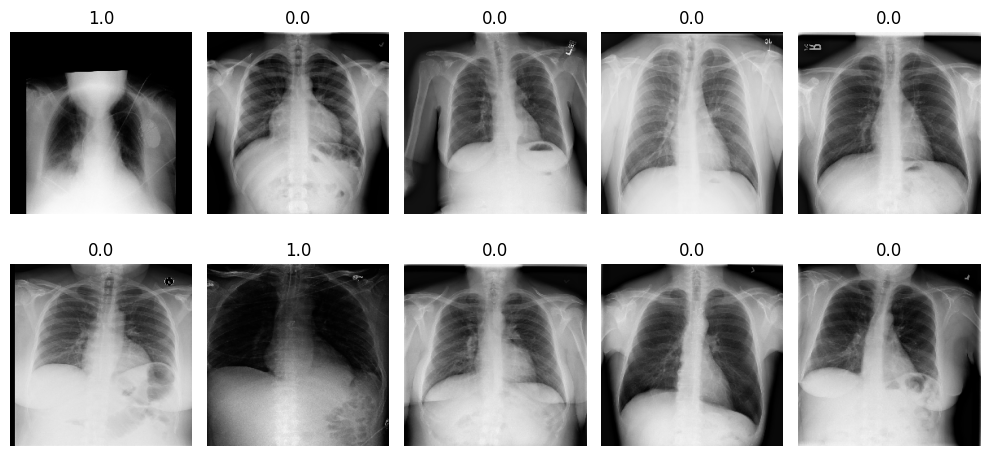

In [9]:
# Genera un batch di immagini e le relative etichette dal generatore di dati di addestramento
images, labels = next(test_gen)
plt.figure(figsize=(10, 5))
# Crea una visualizzazione di 10 immagini e le loro etichette
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_offset = random.randint(1, 10)
    if i+random_offset > len(images): random_offset=0
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')



# Mostra la visualizzazione
print(test_gen.class_indices)
plt.tight_layout()
plt.show()

#DEFINIZIONE DEL MODELLO

In [10]:

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Costruzione del modello CNN aggiornato per immagini 224x224
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), name="primo"),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il primo blocco Conv-Pool

    Conv2D(64, (3, 3), activation='relu', name="secondo"),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il secondo blocco Conv-Pool

    Conv2D(128, (3, 3), activation='relu', name="terzo"),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il terzo blocco Conv-Pool

    Conv2D(256, (3, 3), activation='relu', name="ultimo"),  # Aggiungi un livello con più filtri
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il quarto blocco Conv-Pool

    Flatten(),

    Dense(1024, activation='relu'),  # Aumento del numero di neuroni Fully Connected
    Dropout(0.5),  # Dropout più alto prima del Dense layer finale

    Dense(1, activation='sigmoid')  # Output layer per classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model_path = "/content/drive/MyDrive/AAoMC/model/02"
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ primo (Conv2D)                       │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ secondo (Conv2D)                     │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ terzo (Conv2D)                       │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ultimo (Conv2D)                      │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      37,749,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,139,201 (145.49 MB)

 Trainable params: 38,139,201 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ primo (Conv2D)                       │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ secondo (Conv2D)                     │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ terzo (Conv2D)                       │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ultimo (Conv2D)                      │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      37,749,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,139,201 (145.49 MB)

 Trainable params: 38,139,201 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

None


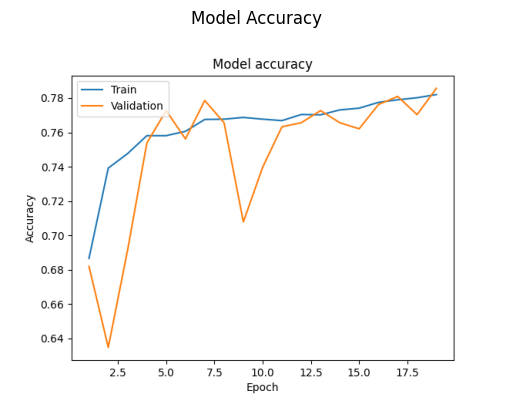

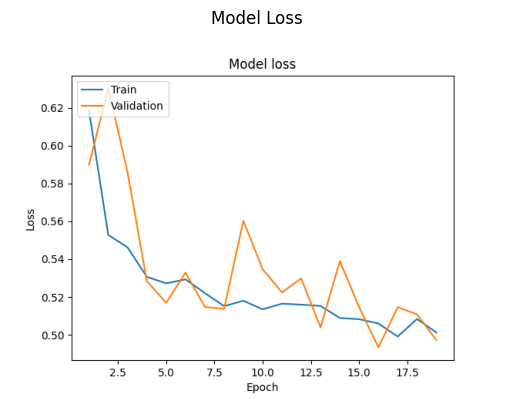


Contenuto di training_history.csv:

    epoch  training_accuracy  training_loss  validation_accuracy  \
0       1           0.686658       0.618534             0.681979   
1       2           0.739218       0.552790             0.634865   
2       3           0.747642       0.546218             0.691402   
3       4           0.758086       0.530621             0.753828   
4       5           0.758086       0.527184             0.772674   
5       6           0.760613       0.529306             0.756184   
6       7           0.767520       0.522099             0.778563   
7       8           0.767689       0.515143             0.765607   
8       9           0.768699       0.517998             0.707892   
9      10           0.767689       0.513461             0.739694   
10     11           0.766846       0.516440             0.763251   
11     12           0.770384       0.515928             0.765607   
12     13           0.770216       0.515244             0.772674   
13     14  

In [11]:
load_model(model, model_path)

#TEST PERFORMANCE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plotta una confusion matrix.
    :param y_true: Le etichette reali.
    :param y_pred: Le etichette predette dal modello.
    :param classes: Lista dei nomi delle classi.
    :param title: Titolo del grafico.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_roc_curve(model, X_test, y_test):
    """
    Plotta la curva ROC e calcola l'AUC (Area Under Curve).
    :param model: Il modello da testare.
    :param X_test: I dati di test.
    :param y_test: Le etichette reali del test set.
    """
    y_pred_prob = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


def classification_report_and_metrics(y_true, y_pred, target_names):
    """
    Stampa il report di classificazione (Precision, Recall, F1-Score) e calcola altre metriche utili.
    :param y_true: Le etichette reali.
    :param y_pred: Le etichette predette dal modello.
    :param target_names: Lista dei nomi delle classi.
    """
    print("Classification Report:")
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)

    # Calcola precision, recall, f1-score per ciascuna classe
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {fscore:.2f}")
    return report


def evaluate_model(model, X_test, y_test, classes):
    """
    Esegue una valutazione completa del modello sui dati di test.
    :param model: Il modello da testare.
    :param X_test: I dati di test.
    :param y_test: Le etichette reali del test set.
    :param classes: Lista dei nomi delle classi.
    """
    # Previsioni
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, classes)

    # Classification Report & Metrics
    classification_report_and_metrics(y_test, y_pred, target_names=classes)

    # ROC Curve (solo per classificazione binaria)
    if len(classes) == 2:
        plot_roc_curve(model, X_test, y_test)


def evaluate_test_loss_accuracy(model, test_gen):
    # Esegue la valutazione del modello sul generatore di test
    test_loss, test_acc = model.evaluate(test_gen)

    # Stampa i risultati
    print(f"Loss sui dati di test: {test_loss}")
    print(f"Accuratezza sui dati di test: {test_acc}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step


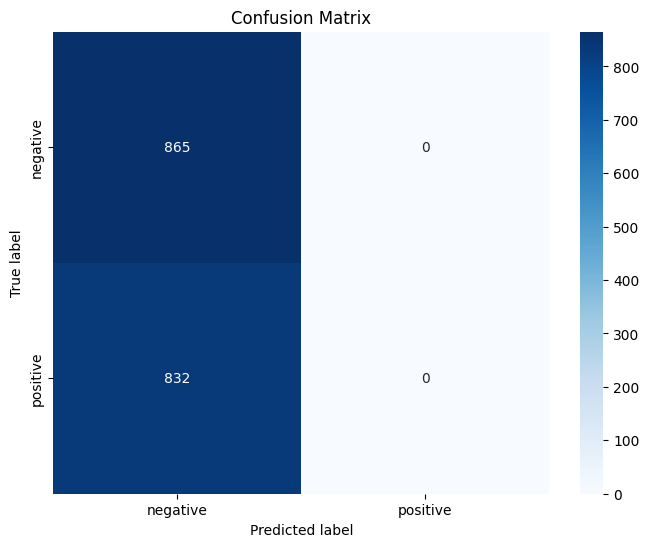

Classification Report:
              precision    recall  f1-score   support

    negative       0.51      1.00      0.68       865
    positive       0.00      0.00      0.00       832

    accuracy                           0.51      1697
   macro avg       0.25      0.50      0.34      1697
weighted avg       0.26      0.51      0.34      1697

Precision: 0.26
Recall: 0.51
F1-Score: 0.34


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 988ms/step


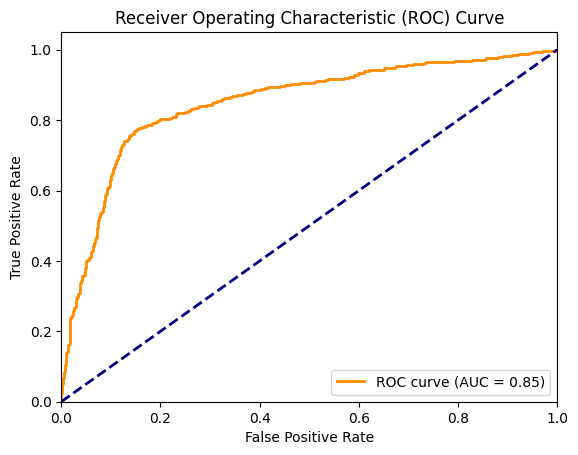

54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 996ms/step - accuracy: 0.7754 - loss: 0.5034
Loss sui dati di test: 0.5012450814247131
Accuratezza sui dati di test: 0.7813789248466492


In [ ]:

# Estrai le etichette predette
#y_pred = np.argmax(pred, axis=1)

# Ottieni le etichette vere
y_test = test_gen.classes

# Ottieni i nomi delle classi
classes = list(test_gen.class_indices.keys())

# Esegui la valutazione completa del modello
evaluate_model(model, test_gen, y_test, classes)

# Calcola e visualizza la perdita e l'accuratezza sui dati di test
evaluate_test_loss_accuracy(model, test_gen)



#GRAD-CAM

{'negative': 0, 'positive': 1}


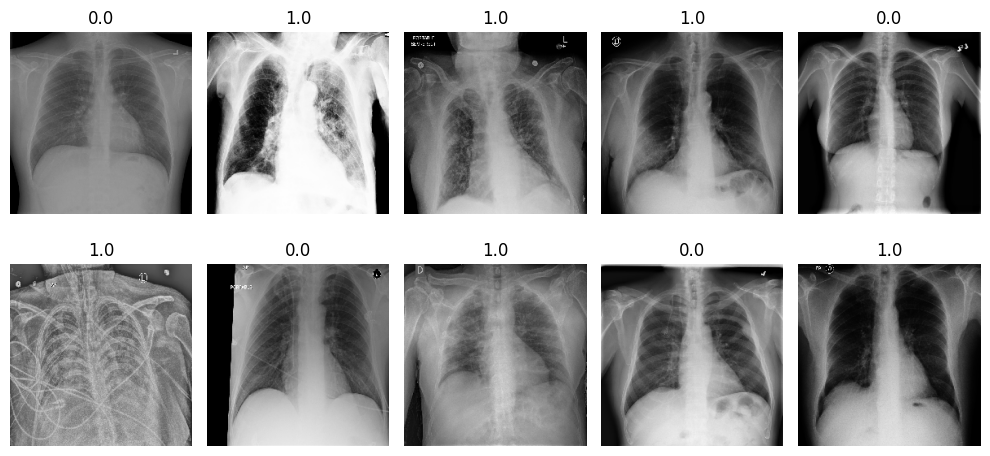

In [ ]:
# Genera un batch di immagini e le relative etichette dal generatore di dati di addestramento
images, labels = next(test_gen)
plt.figure(figsize=(10, 5))
# Crea una visualizzazione di 10 immagini e le loro etichette
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_offset = random.randint(1, 10)
    if i+random_offset > len(images): random_offset=0
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')



# Mostra la visualizzazione
print(test_gen.class_indices)
plt.tight_layout()
plt.show()

In [ ]:
# Genera le predizioni per il test set

y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  # Converte le predizioni in classi binarie

# Ottieni le etichette vere dal generatore
y_true = test_gen.labels

# Trova gli errori
errors = np.where(y_pred_classes != y_true)[0]
print("Number of errors: ", len(errors))

# Trova le predizioni corrette
correct_predictions = np.where(y_pred_classes == y_true)[0]
print("Number of correct predictions: ", len(correct_predictions))


53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step
Number of errors:  574
Number of correct predictions:  1121


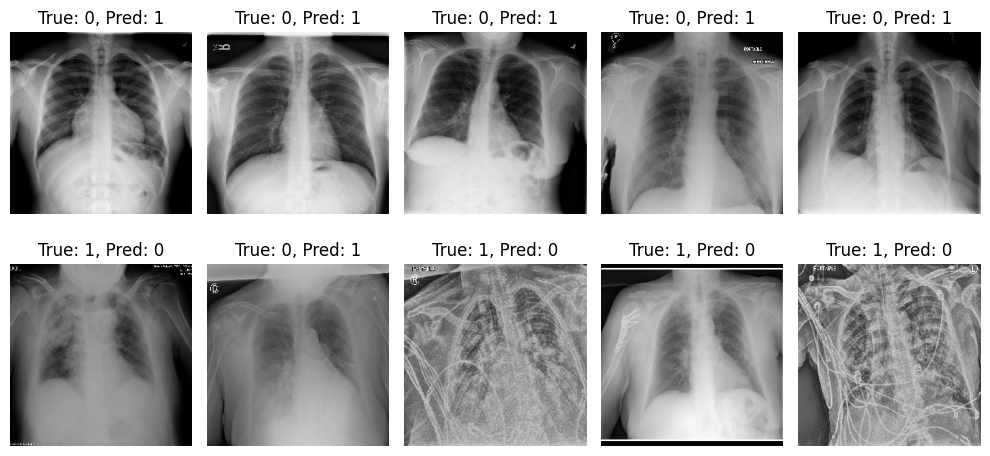

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Seleziona solo 10 immagini classificate male
errors_10 = errors[:10]

# Visualizza 10 immagini classificate male con True Label e Predicted Label
plt.figure(figsize=(10, 5))

for i, idx in enumerate(errors_10):
    # Carica l'immagine originale
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))

    # Ottieni l'immagine come array
    img_array = image.img_to_array(img) / 255.0  # Normalizza l'immagine per la visualizzazione

    # Ottieni il true label e il predicted label
    true_label = y_true[idx]
    predicted_label = y_pred_classes[idx]

    # Visualizza l'immagine con titolo contenente true label e predicted label

    plt.subplot(2, 5, i + 1)  # 2 righe, 5 colonne
    plt.imshow(img_array)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def preprocess_image(img_path, target_size=(224, 224)):
    """
    Funzione per caricare e preprocessare un'immagine data la sua path.

    Args:
        img_path (str): Il percorso dell'immagine.
        target_size (tuple): La dimensione di destinazione per il ridimensionamento dell'immagine.

    Returns:
        img_array (numpy.ndarray): L'immagine preprocessata come input per la funzione make_gradcam_heatmap.
    """
    # Carica l'immagine dal percorso
    img = image.load_img(img_path, target_size=target_size)

    # Converti l'immagine in un array
    img_array = image.img_to_array(img)

    # Aggiungi una dimensione per rappresentare il batch
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocessa l'immagine (ad esempio per MobileNet, o sostituisci con la preprocessione appropriata)
    #img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    img_array = img_array / 255.0


    return img_array



def gradcam(img_path, model, conv_layers):
    """
    Applies Grad-CAM to visualize the regions of the image that contribute to the predictions
    for the specified convolutional layers.
    """

    # Preprocess the input image for Grad-CAM
    img_array = preprocess_image(img_path)
    full_heatmap = []

    for layer in conv_layers:
        # Create a new model that outputs the activations of the convolutional layer and the final predictions
        new_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer).output, model.outputs])

        with tf.GradientTape() as tape:
            # Forward pass
            last_conv_layer_output, preds = new_model(img_array)
            preds = preds[0]

            # Get the predicted class index
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # Compute the gradients of the class channel with respect to the output feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # Pool the gradients across the width and height dimensions
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Compute the heatmap
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # Debug: Verifica valori della heatmap
        print(f"Heatmap for layer {layer}: min = {np.min(heatmap)}, max = {np.max(heatmap)}")

        # Post-process the heatmap: remove negative values and normalize
        heatmap = np.maximum(heatmap, 0)  # ReLU to ensure only positive values
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Normalize between 0 and 1

        full_heatmap.append(heatmap)

    # Load and preprocess the original image
    img_loaded = image.load_img(img_path, target_size=(224, 224))
    img = np.array(img_loaded)

    # Convert heatmaps to 8-bit format and apply the 'jet' colormap
    full_heatmap = [np.uint8(255 * heatmap) for heatmap in full_heatmap]
    jet = plt.colormaps.get_cmap("jet")  # Updated colormap function

    jet_heatmaps = []
    for heatmap in full_heatmap:
        # Apply the colormap to the heatmap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Convert to image format and resize to match the original image dimensions
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = np.array(jet_heatmap)
        jet_heatmaps.append(jet_heatmap)

    # Number of heatmaps to display
    num_heatmaps = len(jet_heatmaps)

    # Create a figure to display the original image, heatmaps, and superimposed image
    fig, axes = plt.subplots(1, num_heatmaps + 2, figsize=(5 * (num_heatmaps + 2), 6))

    # Display the original image
    axes[0].imshow(img.astype("uint8"))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the heatmaps
    for i in range(num_heatmaps):
        axes[i + 1].imshow(jet_heatmaps[i].astype("uint8"))
        axes[i + 1].set_title(f"Grad-CAM Heatmap {i+1}")
        axes[i + 1].axis('off')

    # Superimpose the last heatmap on the original image
    final_heatmap = jet_heatmaps[-1]
    superimposed_img = np.uint8(final_heatmap * 0.4 + img * 0.6)
    axes[num_heatmaps + 1].imshow(superimposed_img)
    axes[num_heatmaps + 1].set_title("Final Result")
    axes[num_heatmaps + 1].axis('off')

    plt.show()


In [ ]:
gradcam(test_gen.filepaths[70],model,["primo", "secondo", "terzo", "ultimo"])